In [1]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

In [2]:
training_data = datasets.MNIST(root = "data", train = True, download = True, transform = ToTensor())
test_data = datasets.MNIST(root = "data", train = False, download = True, transform = ToTensor())

In [3]:
train_loader = DataLoader(training_data, batch_size = 64, shuffle = True)
test_loader = DataLoader(test_data, batch_size = 64, shuffle = True)

In [4]:
device = ("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

Using cuda device


In [5]:
#create a neural network with two linear layers, applying ReLU each time afterwards
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten() #removes the first dimension of the image to make it a 28 * 28 array
        self.linear_ReLU_stack = nn.Sequential(
            nn.Linear(28 * 28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512,10))
        
    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_ReLU_stack(x)
        return logits

In [6]:
model = NeuralNetwork().to(device)

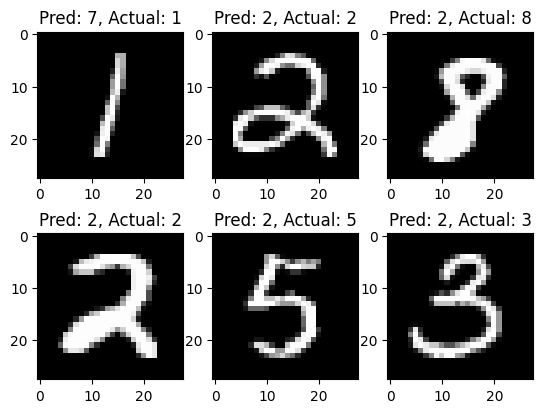

In [7]:
#See how bad the model is before training!
imgs, labels = next(iter(train_loader))
imgs = imgs.to(device)
labels = labels.to(device)

logits = model(imgs[:6])

preds_prob = nn.Softmax(dim = 1)(logits)

import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(6):
    fig.add_subplot(2,3,i+1)
    plt.title(f"Pred: {preds_prob.argmax(dim = 1)[i]}, Actual: {labels[i]}")
    plt.imshow(imgs[i].to('cpu').numpy().squeeze(), cmap = 'grey')

In [8]:
#hypers
learning_rate = 1e-3
batch_size = 64
loss_fn = torch.nn.CrossEntropyLoss()
epochs = 20

#optimizer
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)

def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    # Set the model to training mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        #move to GPU
        X = X.to(device)
        y = y.to(device)
        
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * batch_size + len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test_loop(dataloader, model, loss_fn):
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            #move to GPU
            X = X.to(device)
            y = y.to(device)
        
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [9]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_loader, model, loss_fn, optimizer)
    test_loop(test_loader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.305286  [   64/60000]
loss: 2.299861  [ 6464/60000]
loss: 2.294949  [12864/60000]
loss: 2.290570  [19264/60000]
loss: 2.290020  [25664/60000]
loss: 2.286192  [32064/60000]
loss: 2.266290  [38464/60000]
loss: 2.274130  [44864/60000]
loss: 2.271485  [51264/60000]
loss: 2.254202  [57664/60000]
Test Error: 
 Accuracy: 37.9%, Avg loss: 2.259329 

Epoch 2
-------------------------------
loss: 2.254514  [   64/60000]
loss: 2.247247  [ 6464/60000]
loss: 2.249919  [12864/60000]
loss: 2.247612  [19264/60000]
loss: 2.223639  [25664/60000]
loss: 2.230983  [32064/60000]
loss: 2.204228  [38464/60000]
loss: 2.187809  [44864/60000]
loss: 2.215407  [51264/60000]
loss: 2.201235  [57664/60000]
Test Error: 
 Accuracy: 60.0%, Avg loss: 2.195163 

Epoch 3
-------------------------------
loss: 2.204925  [   64/60000]
loss: 2.182578  [ 6464/60000]
loss: 2.181193  [12864/60000]
loss: 2.187207  [19264/60000]
loss: 2.153563  [25664/60000]
loss: 2.140865  [32064/600

In [10]:
#see some example outputs
x, y = next(iter(test_loader))
logits = model(x.to(device))

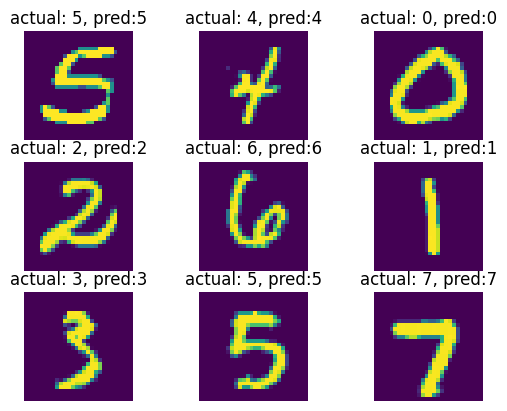

In [11]:
fig = plt.figure()
for i, img in enumerate(x[:9]):
    fig.add_subplot(3,3, i+1)
    plt.title(f'actual: {y[i].item()}, pred:{logits.argmax(dim = 1)[i]}')
    plt.axis('off')
    plt.imshow(x[i].squeeze())

In [12]:
#save the model
torch.save(model, "model.pth")
torch.save(model.state_dict(), "model_weights.pth" )

In [13]:
#check that we can load the model properly
loaded_model = torch.load('model.pth')
loaded_model.load_state_dict(torch.load('model_weights.pth'))

<All keys matched successfully>

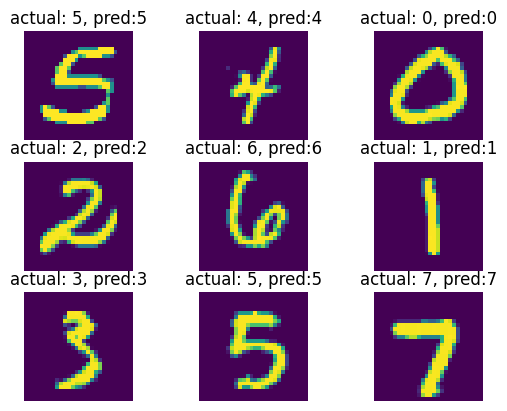

In [14]:
#if this is the same model, it should give the same outputs as above!
logits = loaded_model(x.to(device))
fig = plt.figure()
for i, img in enumerate(x[:9]):
    fig.add_subplot(3,3, i+1)
    plt.title(f'actual: {y[i].item()}, pred:{logits.argmax(dim = 1)[i]}')
    plt.axis('off')
    plt.imshow(x[i].squeeze())